# Lab 02: Softmax Regression

## Notebook 02: Modeling

## **1. Import Libraries**

In [40]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from src import utils as utils
from src import preprocessing as pp

## **2. Model Implementation**

### SoftmaxRegression includes:
- `__init__`: Initialize parameters, weights, bias, history
- `_softmax`: Softmax function
- `_one_hot`: Convert labels to one-hot
- `_compute_accuracy`: Calculate accuracy
- `_cross_entropy_loss`: Calculate cross-entropy loss
- `fit`: Train the model
- `predict`: Predict labels
- `predict_proba`: Predict probabilities
- `evaluate`: Evaluate the model


In [41]:
class SoftmaxRegression:
    def __init__(self, num_classes=10, lr=0.1, num_epochs=2000, batch_size=128):
        self.num_classes = num_classes
        self.lr = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.W = None
        self.b = None
        self.history = {
            'loss': [],
            'train_acc': [],
            'val_acc': []
        }
    def _softmax(self, z):
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot(self, y):
        N = y.shape[0]
        y_oh = np.zeros((N, self.num_classes))
        y_oh[np.arange(N), y] = 1
        return y_oh
    
    def _compute_accuracy(self, X, y):
        probs = self._softmax(np.dot(X, self.W) + self.b)
        preds = np.argmax(probs, axis=1)
        return np.mean(preds == y)

    def _cross_entropy_loss(self, probs, y_oh):
        N = probs.shape[0]
        return -np.sum(y_oh * np.log(probs + 1e-9)) / N
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        N, D = X_train.shape

        if self.W is None:
            self.W = 0.01 * np.random.randn(D, self.num_classes).astype(np.float32)
            self.b = np.zeros((1, self.num_classes), dtype=np.float32)

        y_train_oh = self._one_hot(y_train)
        num_batches = int(np.ceil(N / self.batch_size))

        for epoch in range(self.num_epochs):
            indices = np.random.permutation(N)
            X_train_shuffled = X_train[indices]
            y_train_oh_shuffled = y_train_oh[indices]

            epoch_loss = 0

            for i in range(num_batches):
                start = i * self.batch_size
                end = min((i + 1) * self.batch_size, N)

                X_batch = X_train_shuffled[start:end]
                y_batch_oh = y_train_oh_shuffled[start:end]
                B = X_batch.shape[0]

                logits = np.dot(X_batch, self.W) + self.b
                probs = self._softmax(logits)

                batch_loss = self._cross_entropy_loss(probs, y_batch_oh)
                epoch_loss += batch_loss

                dlogits = (probs - y_batch_oh) / B
                dW = np.dot(X_batch.T, dlogits)
                db = np.sum(dlogits, axis=0, keepdims=True)

                self.W -= self.lr * dW
                self.b -= self.lr * db

            avg_loss = epoch_loss / num_batches
            train_acc = self._compute_accuracy(X_train, y_train)

            self.history['loss'].append(avg_loss)
            self.history['train_acc'].append(train_acc)

            if epoch % 10 == 0:
                msg = f"Epoch {epoch+1}/{self.num_epochs} - loss={avg_loss:.4f} - train_acc={train_acc:.4f}"

                if X_val is not None and y_val is not None:
                    val_acc = self._compute_accuracy(X_val, y_val)
                    self.history['val_acc'].append(val_acc)
                    msg += f" - val_acc={val_acc:.4f}"

                print(msg)
    def predict(self, X):
        probs = self._softmax(np.dot(X, self.W) + self.b)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        return self._softmax(np.dot(X, self.W) + self.b)

    def evaluate(self, X, y):
        probs = self._softmax(np.dot(X, self.W) + self.b)
        y_oh = self._one_hot(y)
        loss = self._cross_entropy_loss(probs, y_oh)
        acc = np.mean(np.argmax(probs, axis=1) == y)
        return loss, acc

## **3. Evaluation**

Use the following metrics to evaluate the model: 
- Accuracy
- Precision, Recall, and F1-score
- Confusion matrix visualization

*Accuracy*

In [42]:
def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

*Precision, Recall, and F1-score*

In [43]:
def compute_classification_metrics(conf_matrix):
    num_classes = conf_matrix.shape[0]

    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tp
        fn = np.sum(conf_matrix[i, :]) - tp

        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1[i] = (
            2 * precision[i] * recall[i] / (precision[i] + recall[i])
            if (precision[i] + recall[i]) > 0
            else 0
        )

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "macro_precision": precision.mean(),
        "macro_recall": recall.mean(),
        "macro_f1": f1.mean(),
    }

*Confusion matrix*

In [44]:
def compute_confusion_matrix(y_true, y_pred, num_classes=10):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

## **4. Main**

**Load MNIST Dataset**

In [45]:
X_train, y_train, X_test, y_test = utils.load_mnist()

### **4.1 Method 1: Normalization**

*Load Data & Apply Method 1*

In [46]:
X_train_1, y_train_1, X_test_1, y_test_1 = pp.normalization_Function(X_train, y_train, X_test, y_test)

print(f"Train shape: {X_train_1.shape}, Labels: {y_train_1.shape}")

Train shape: (60000, 784), Labels: (60000,)


*Model Definition*

In [47]:
model1 = SoftmaxRegression(
    num_classes=10,
    lr=0.1,
    num_epochs=50,
    batch_size=128
)

*Model Training*

In [48]:
model1.fit(X_train_1, y_train_1)

Epoch 1/50 - loss=0.5727 - train_acc=0.8914
Epoch 11/50 - loss=0.2873 - train_acc=0.9208
Epoch 21/50 - loss=0.2714 - train_acc=0.9258
Epoch 31/50 - loss=0.2639 - train_acc=0.9280
Epoch 41/50 - loss=0.2585 - train_acc=0.9292


*Prediction*

In [49]:
predictions = model1.predict(X_test_1)

*Training Loss Visualization*

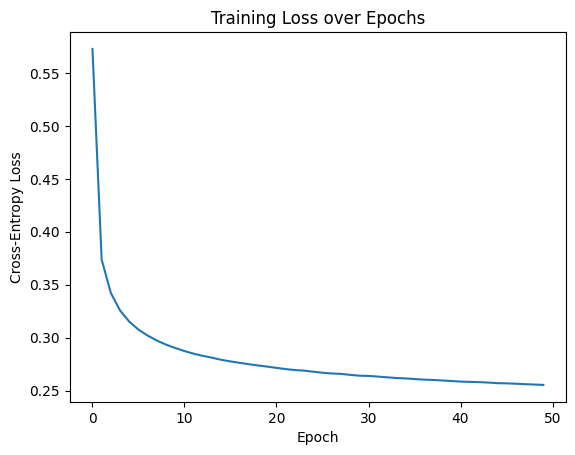

In [50]:
plt.plot(model1.history['loss'])
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()

*Model Evaluation*

In [51]:
acc = compute_accuracy(y_test_1, predictions)
conf_matrix = compute_confusion_matrix(y_test_1, predictions, num_classes=10)
metrics = compute_classification_metrics(conf_matrix)

In [52]:
print(f"Test Accuracy: {acc * 100:.2f}%")

Test Accuracy: 92.51%


*Result Visualization*

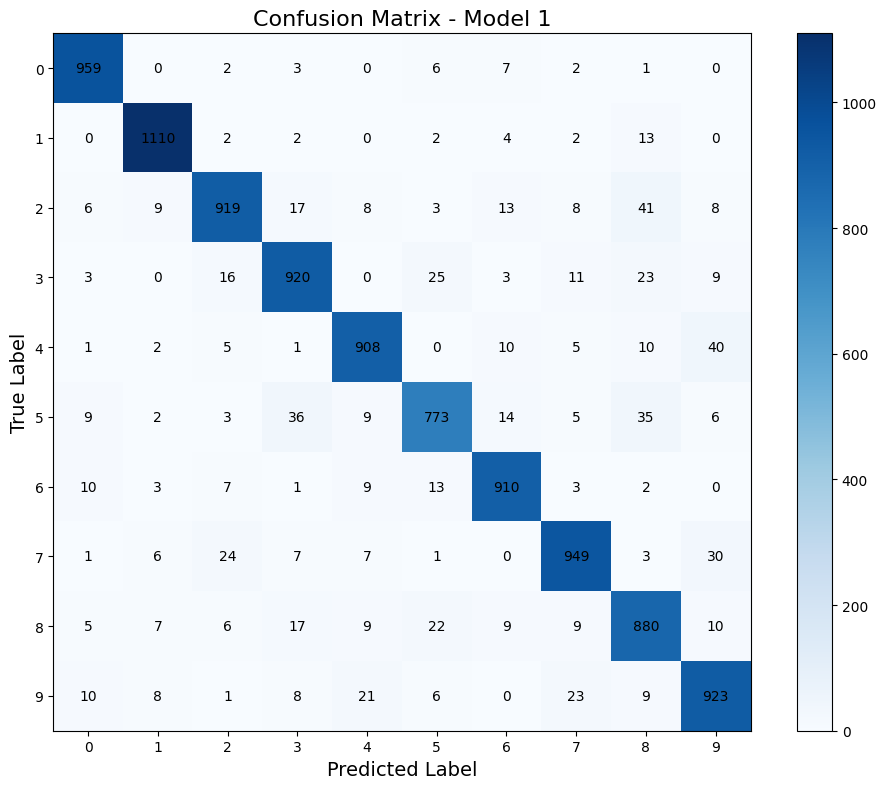

In [53]:
utils.plot_confusion_matrix(conf_matrix, title="Confusion Matrix - Model 1")

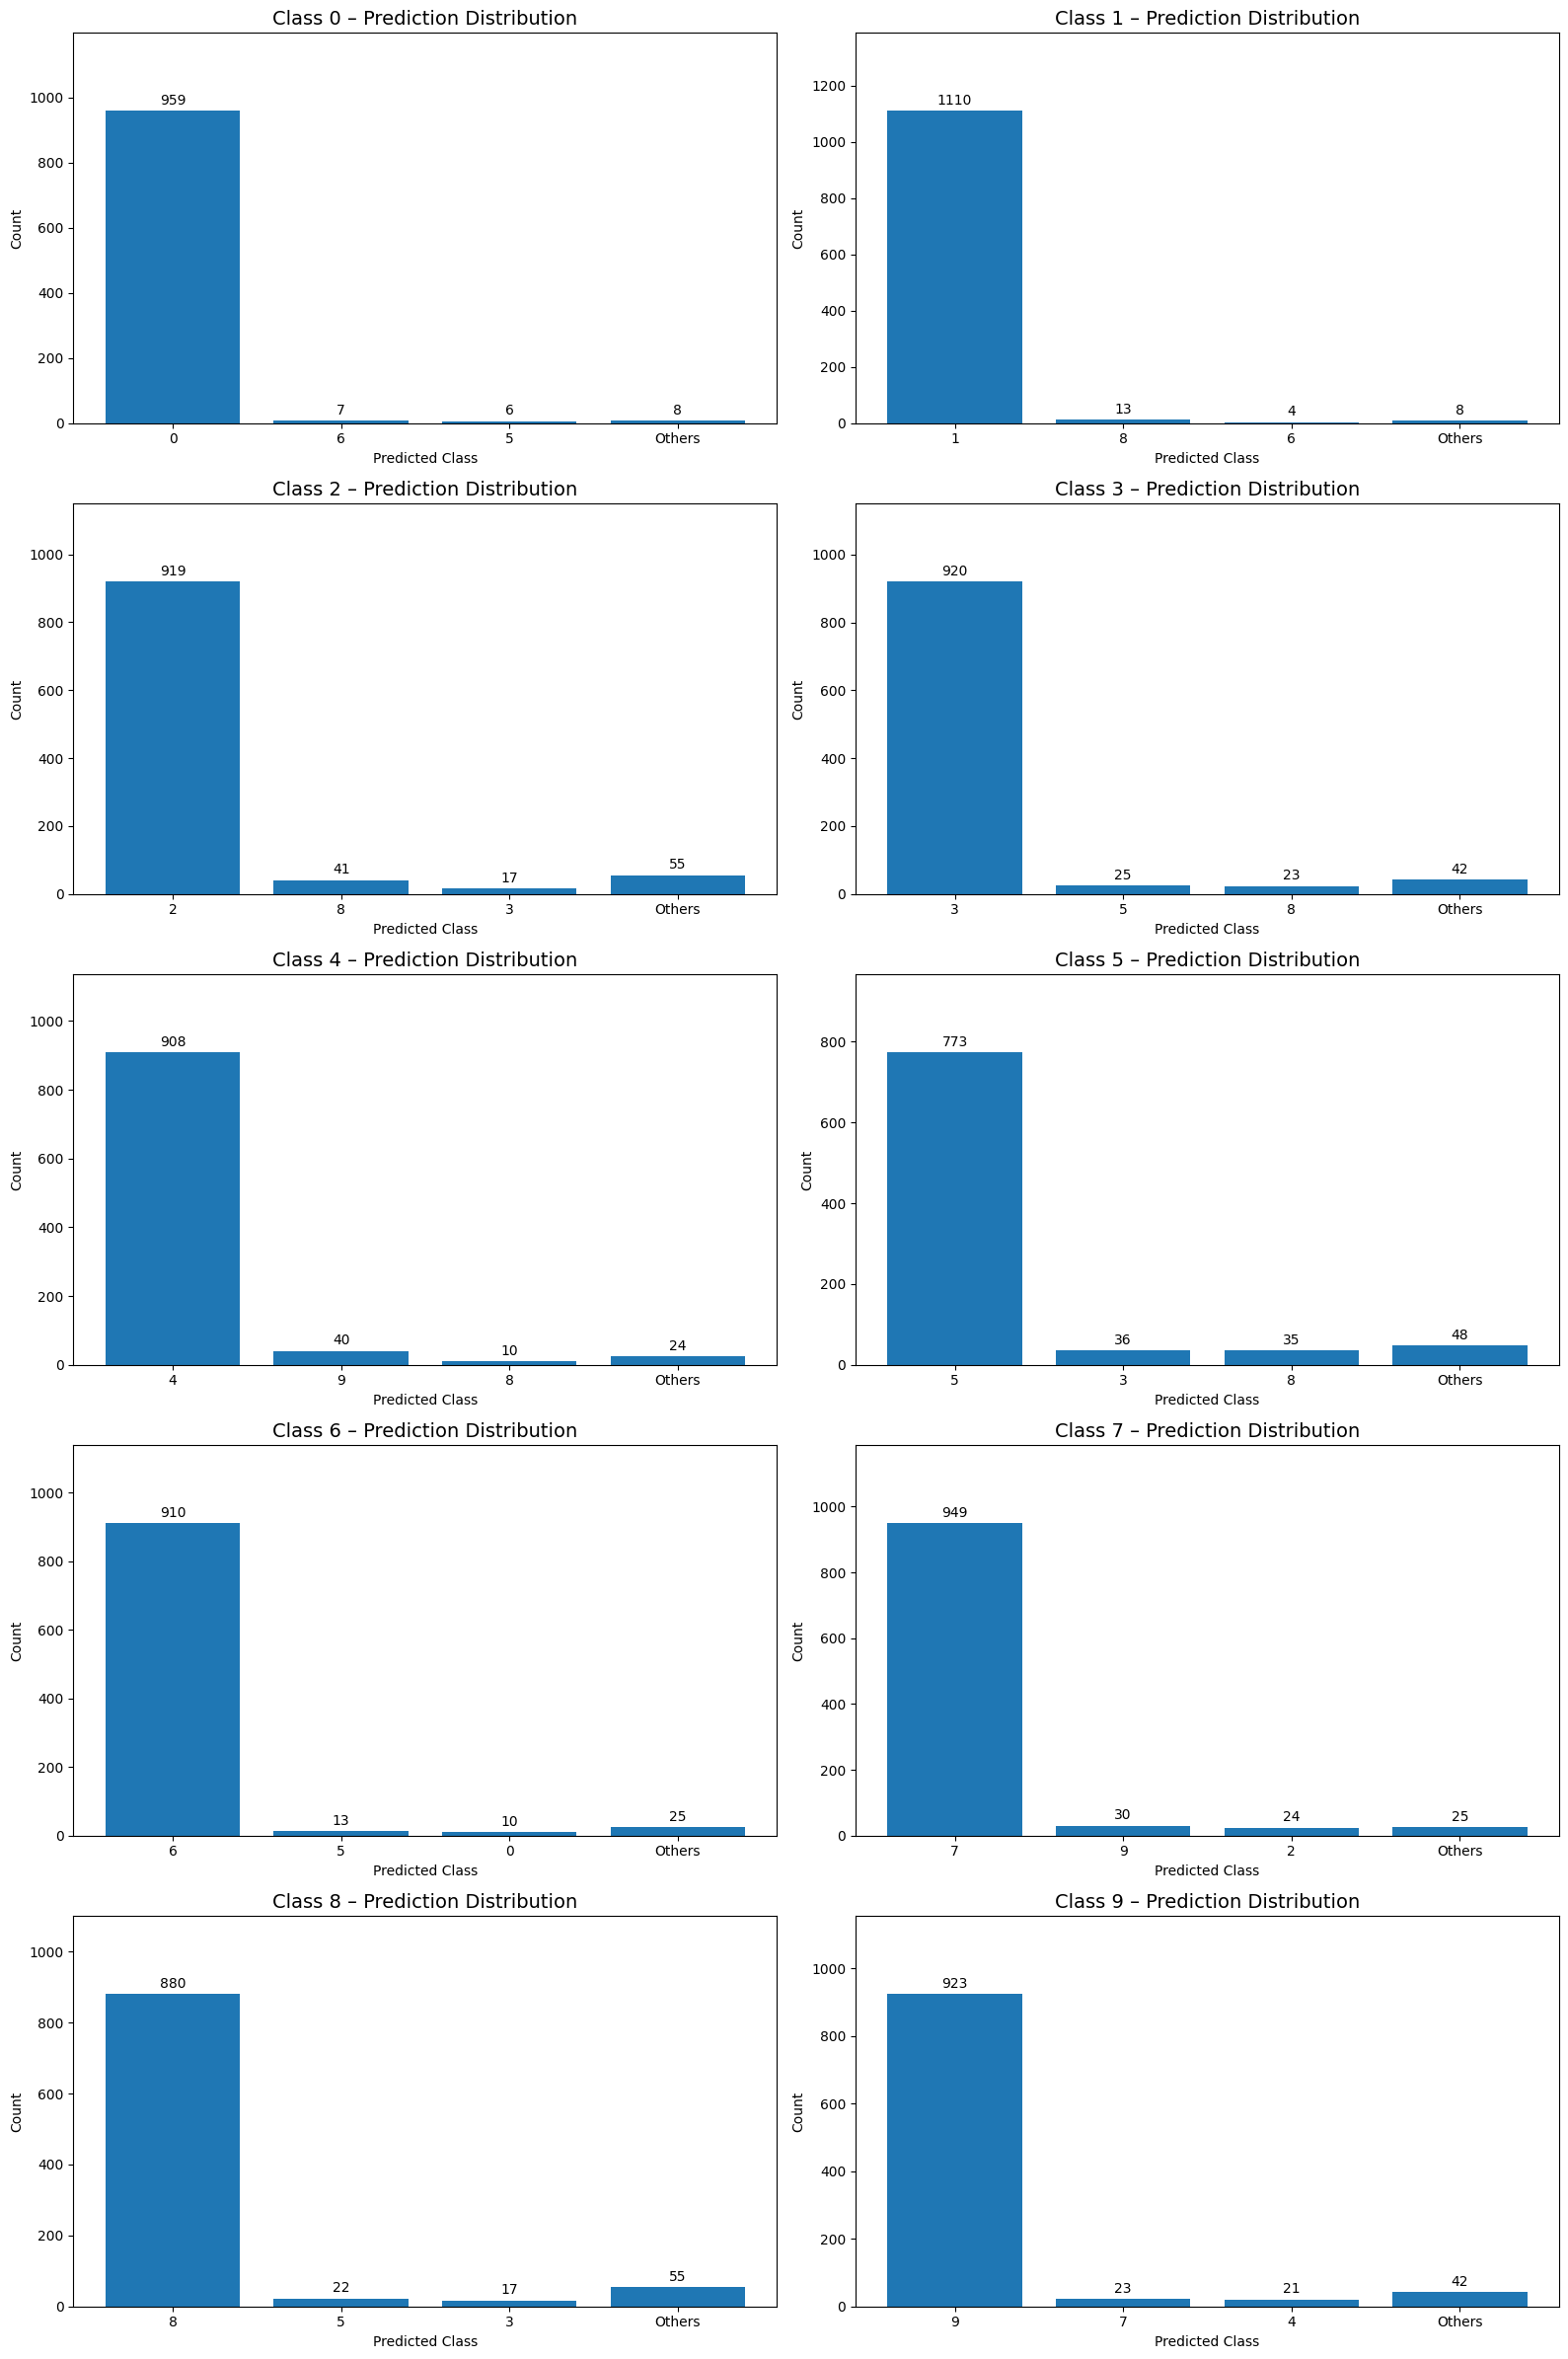

In [54]:
utils.plot_confusion_insights(conf_matrix)

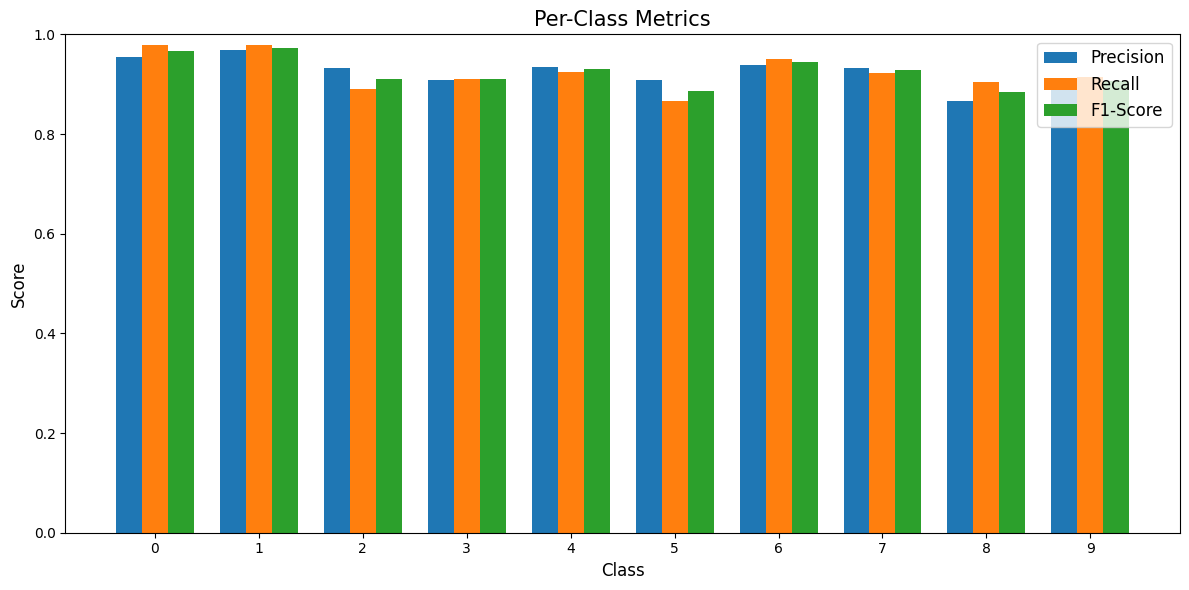

In [55]:
utils.plot_class_metrics(metrics)

### **4.2 Method 2: Edge Normalization**

*Load Data & Apply Method 2*

In [56]:
X_train_2, y_train_2, X_test_2, y_test_2 = pp.edge_normalization_Function(X_train, y_train, X_test, y_test)

print(f"Train shape: {X_train_2.shape}, Labels: {y_train_2.shape}")

Train shape: (60000, 1568), Labels: (60000,)


*Visualize Processed Image*

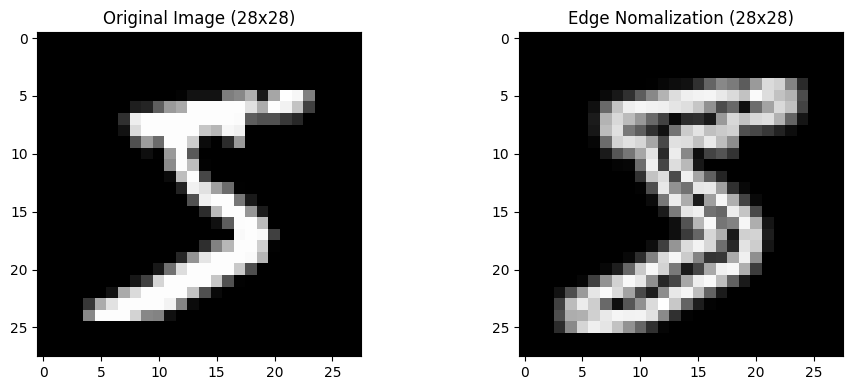

In [57]:
utils.visualize_processed_image(0, X_train, X_train_2)

*Model Definition*

In [58]:
model2 = SoftmaxRegression(
    num_classes=10,
    lr=0.1,
    num_epochs=50,
    batch_size=128
)

*Model Training*

In [59]:
model2.fit(X_train_2, y_train_2)

Epoch 1/50 - loss=0.4731 - train_acc=0.9076
Epoch 11/50 - loss=0.2236 - train_acc=0.9388
Epoch 21/50 - loss=0.2018 - train_acc=0.9448
Epoch 31/50 - loss=0.1902 - train_acc=0.9484
Epoch 41/50 - loss=0.1821 - train_acc=0.9498


*Prediction*

In [60]:
predictions = model2.predict(X_test_2)

*Training Loss Visualization*

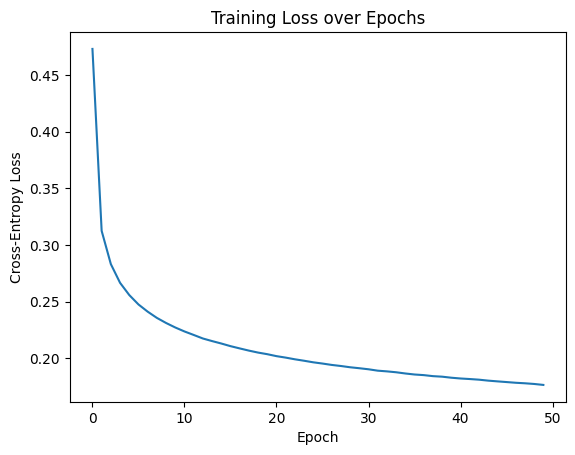

In [61]:
plt.plot(model2.history['loss'])
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()

*Model Evaluation*

In [62]:
acc = compute_accuracy(y_test_2, predictions)
conf_matrix = compute_confusion_matrix(y_test_2, predictions, num_classes=10)
metrics = compute_classification_metrics(conf_matrix)

In [63]:
print(f"Test Accuracy: {acc * 100:.2f}%")

Test Accuracy: 94.37%


*Result Visualization*

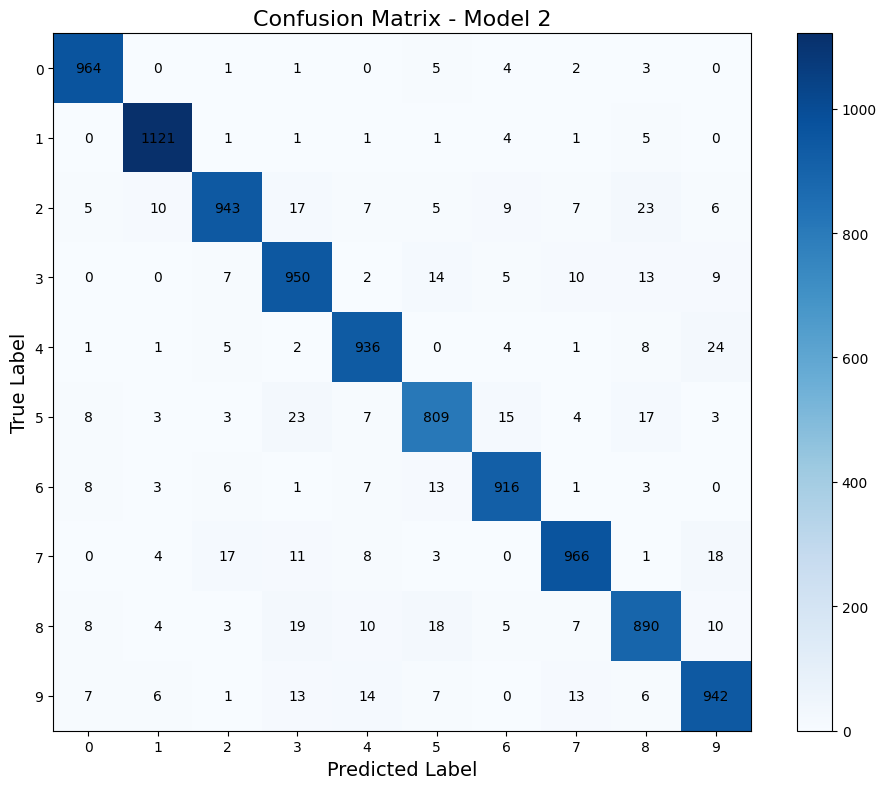

In [64]:
utils.plot_confusion_matrix(conf_matrix, title="Confusion Matrix - Model 2")

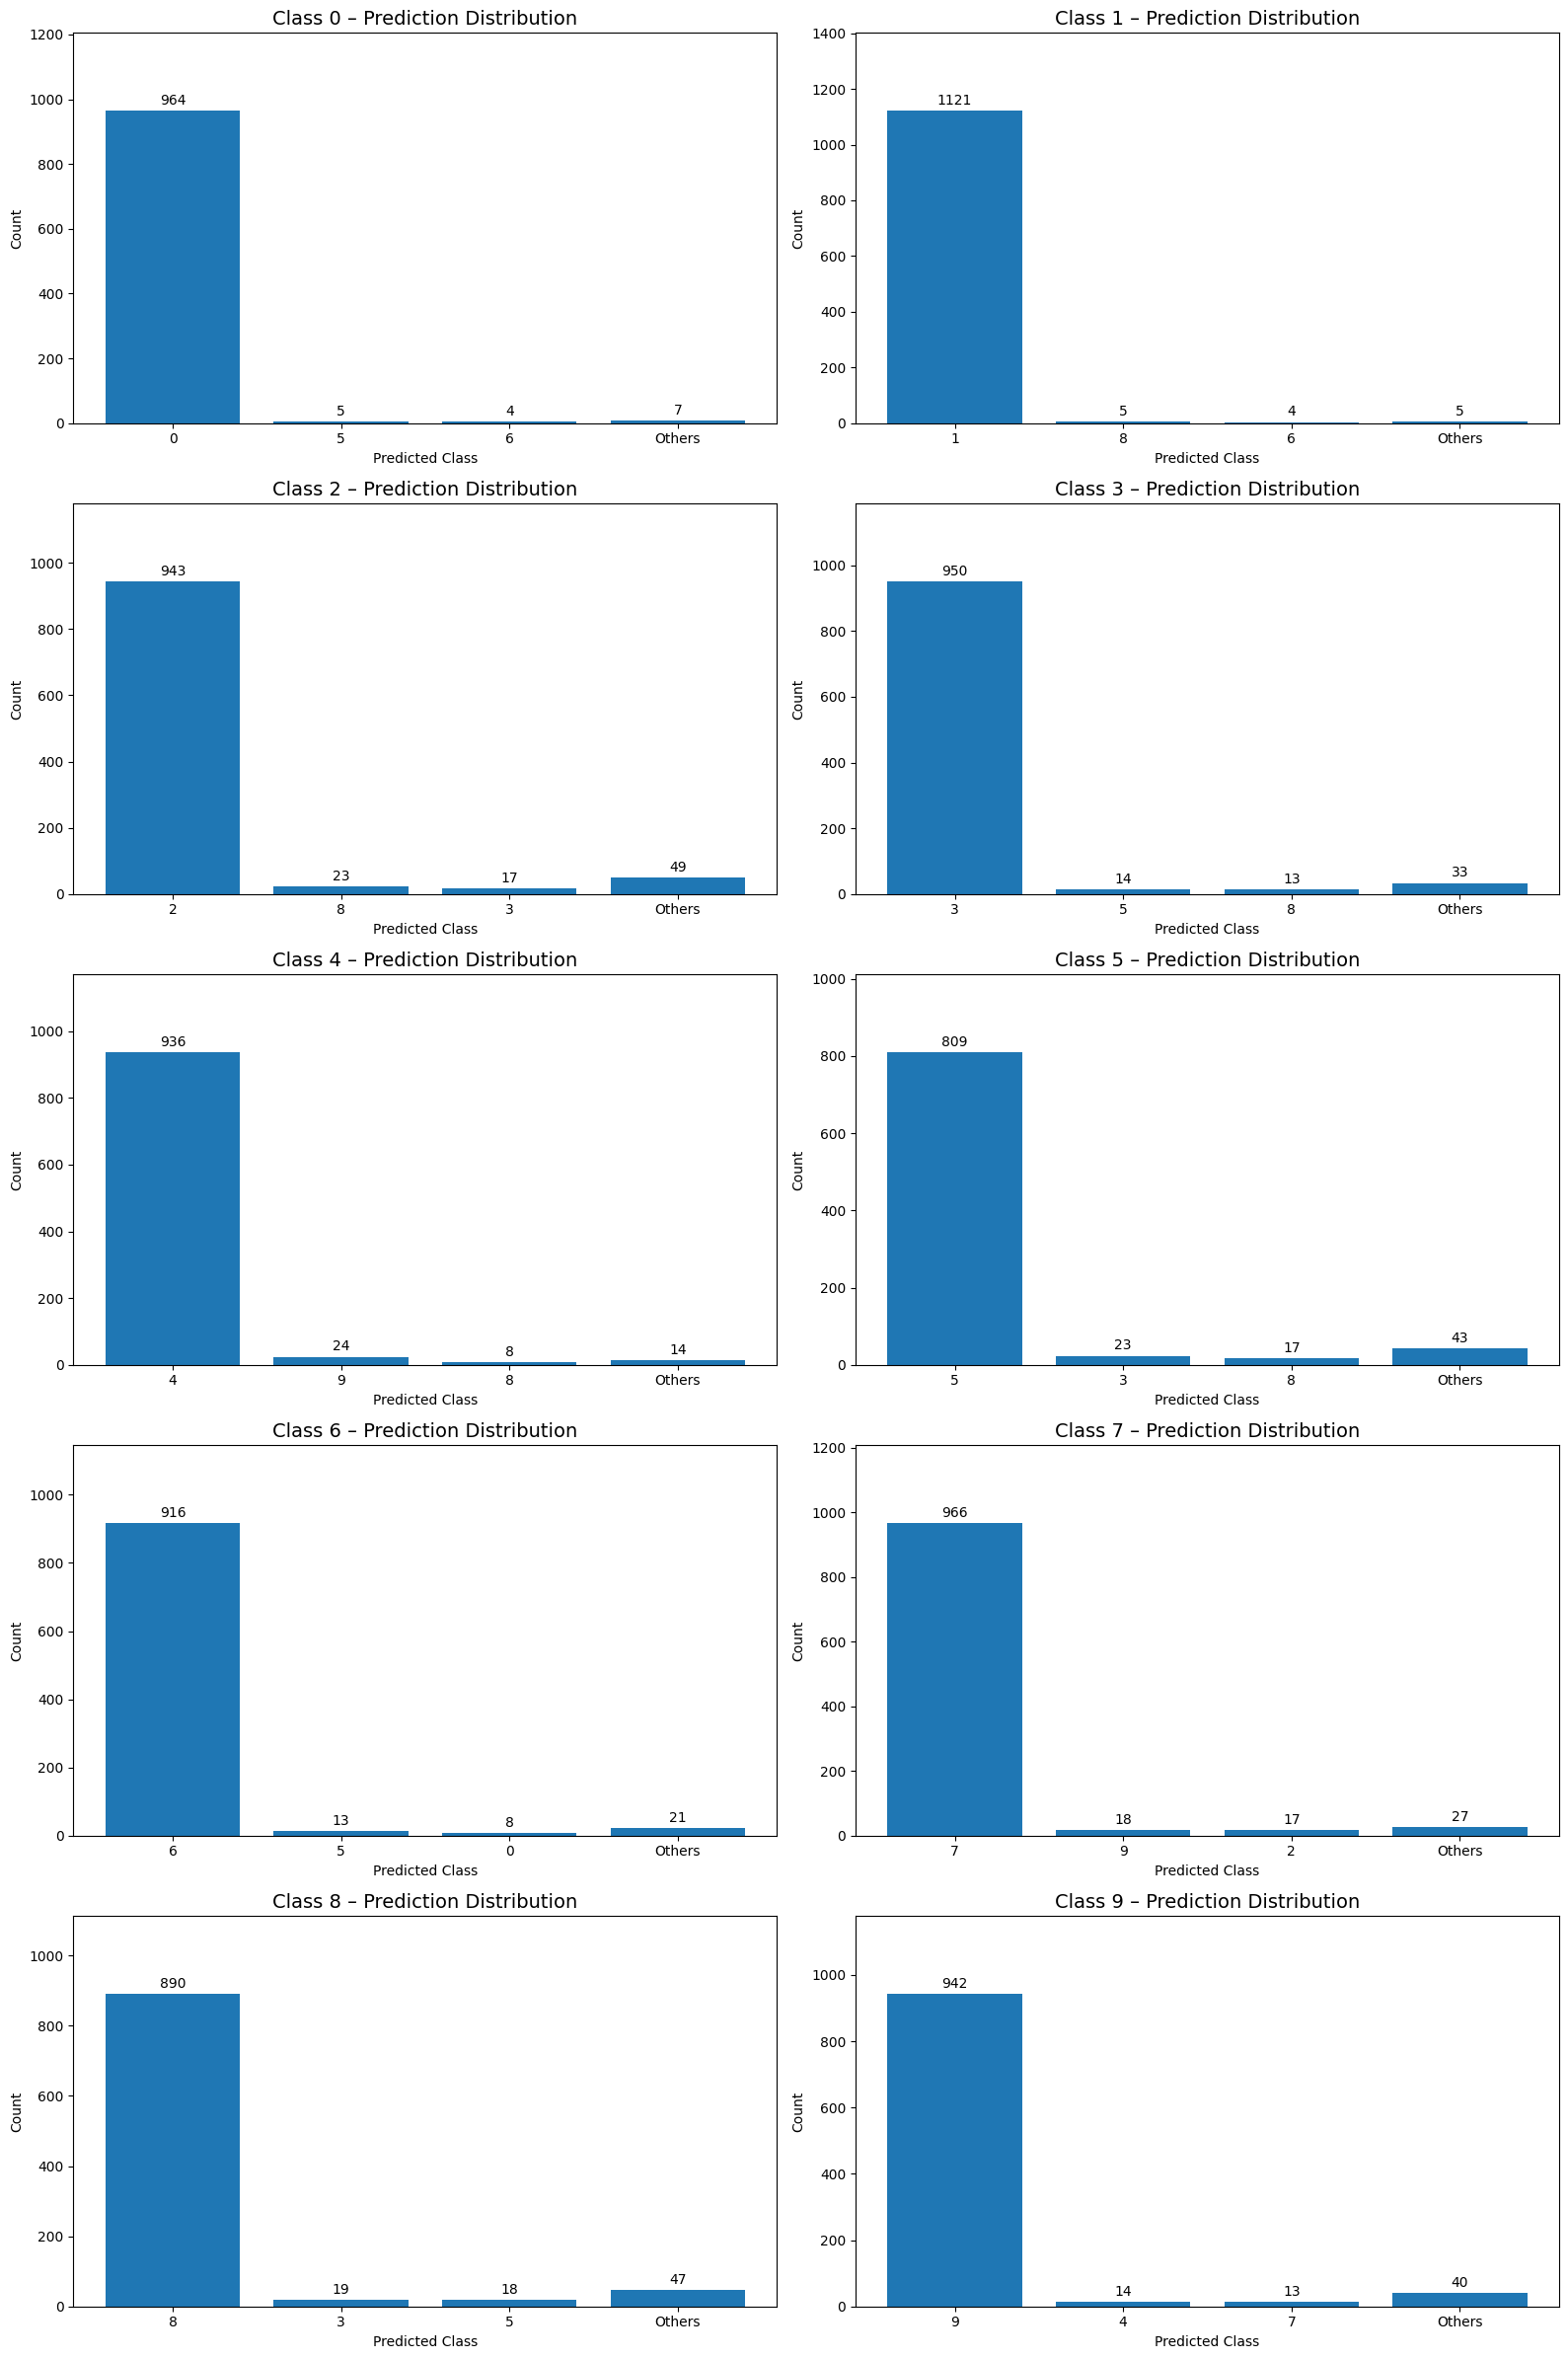

In [65]:
utils.plot_confusion_insights(conf_matrix)

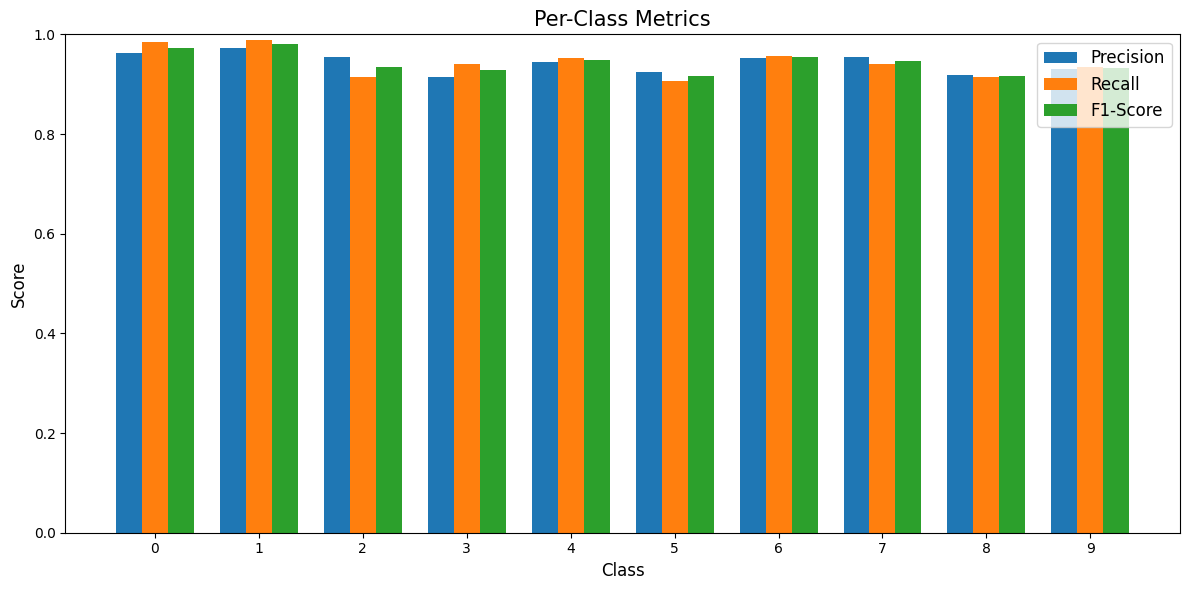

In [66]:
utils.plot_class_metrics(metrics)

### **4.3 Method 3: Block Averaging**

*Load Data & Apply Method 3*

In [67]:
X_train_3, y_train_3, X_test_3, y_test_3 = pp.block_averaging_Function(X_train, y_train, X_test, y_test)

print(f"Train shape: {X_train_3.shape}, Labels: {y_train_3.shape}")

Train shape: (60000, 196), Labels: (60000,)


*Visualize Processed Image*

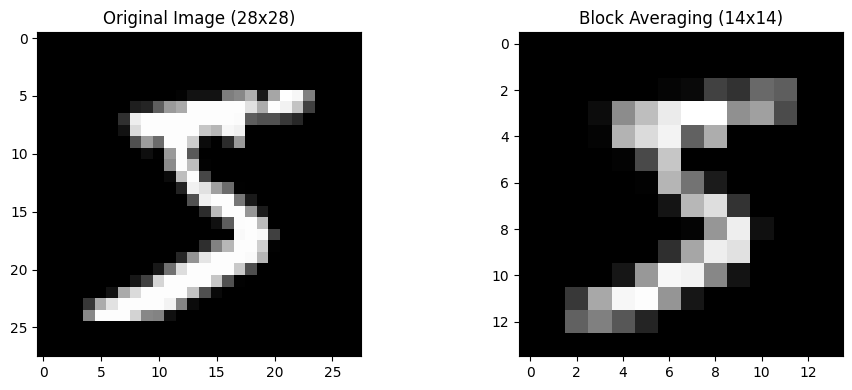

In [68]:
utils.visualize_processed_image(0, X_train, X_train_3)

*Model Definition*

In [69]:
model3 = SoftmaxRegression(
    num_classes=10,
    lr=0.1,
    num_epochs=50,
    batch_size=128
)

*Model Training*

In [70]:
model3.fit(X_train_3, y_train_3)

Epoch 1/50 - loss=0.9411 - train_acc=0.8630
Epoch 11/50 - loss=0.3450 - train_acc=0.9047
Epoch 21/50 - loss=0.3181 - train_acc=0.9111
Epoch 31/50 - loss=0.3060 - train_acc=0.9135
Epoch 41/50 - loss=0.2991 - train_acc=0.9161


*Prediction*

In [71]:
predictions = model3.predict(X_test_3)

*Training Loss Visualization*

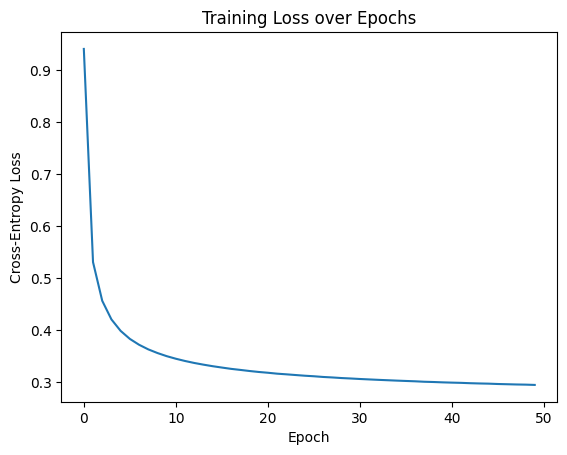

In [72]:
plt.plot(model3.history['loss'])
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()

*Model Evaluation*

In [73]:
acc = compute_accuracy(y_test_3, predictions)
conf_matrix = compute_confusion_matrix(y_test_3, predictions, num_classes=10)
metrics = compute_classification_metrics(conf_matrix)

In [74]:
print(f"Test Accuracy: {acc * 100:.2f}%")

Test Accuracy: 92.02%


*Result Visualization*

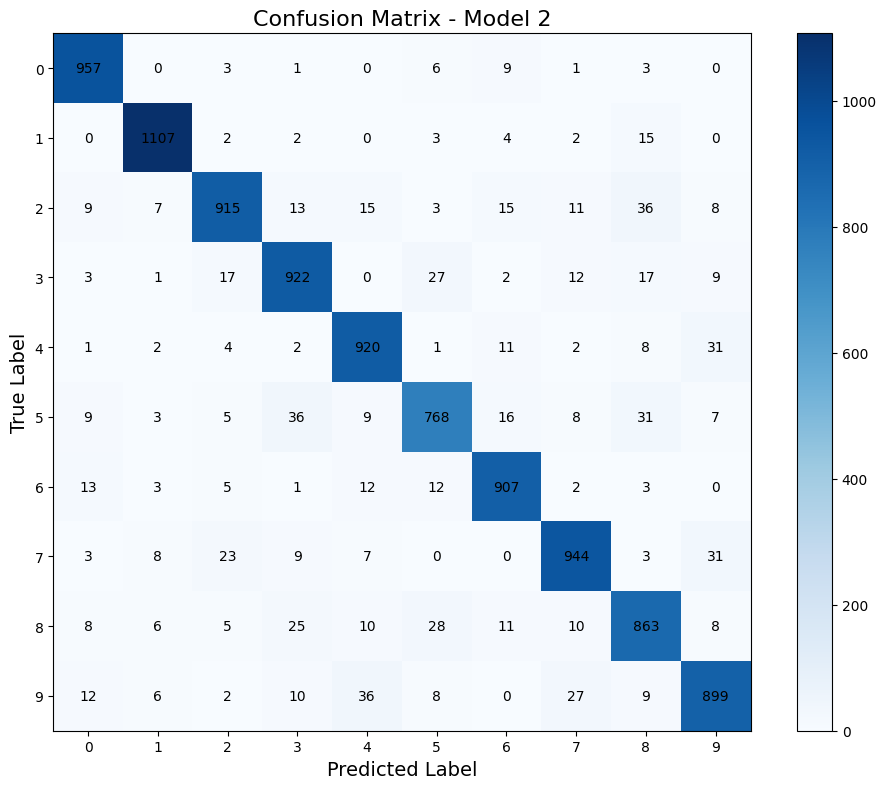

In [75]:
utils.plot_confusion_matrix(conf_matrix, title="Confusion Matrix - Model 2")

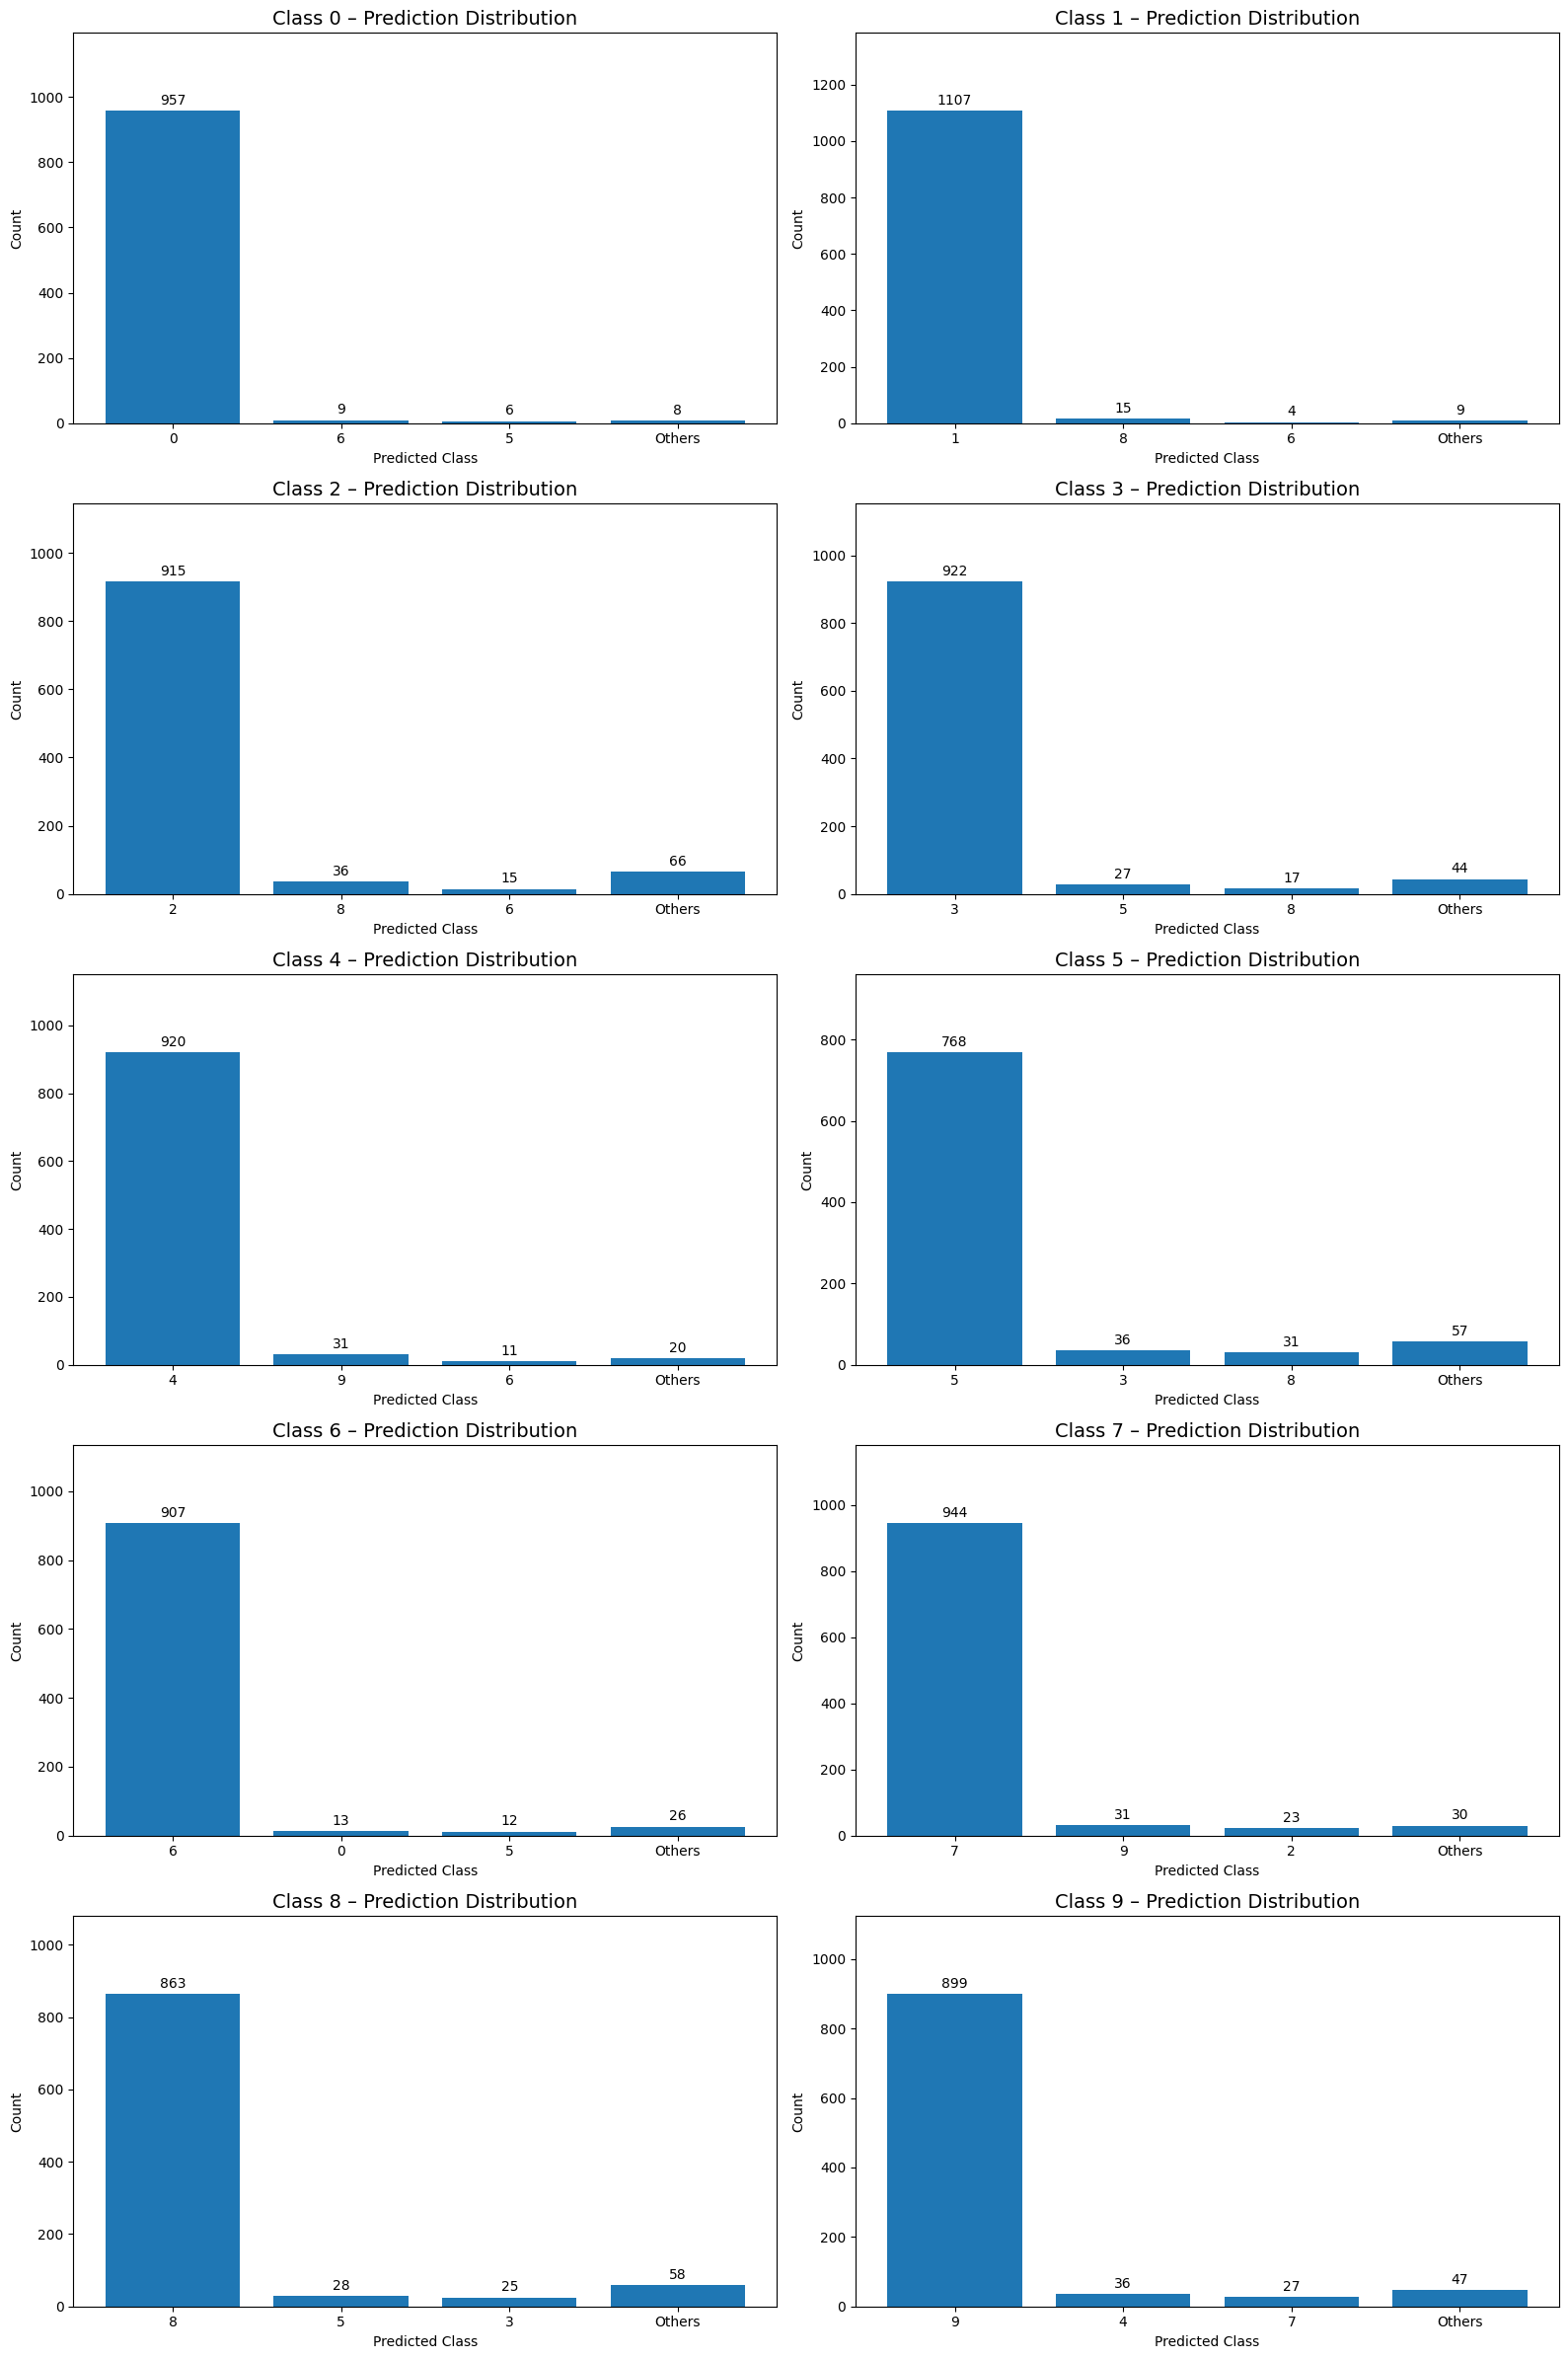

In [76]:
utils.plot_confusion_insights(conf_matrix)

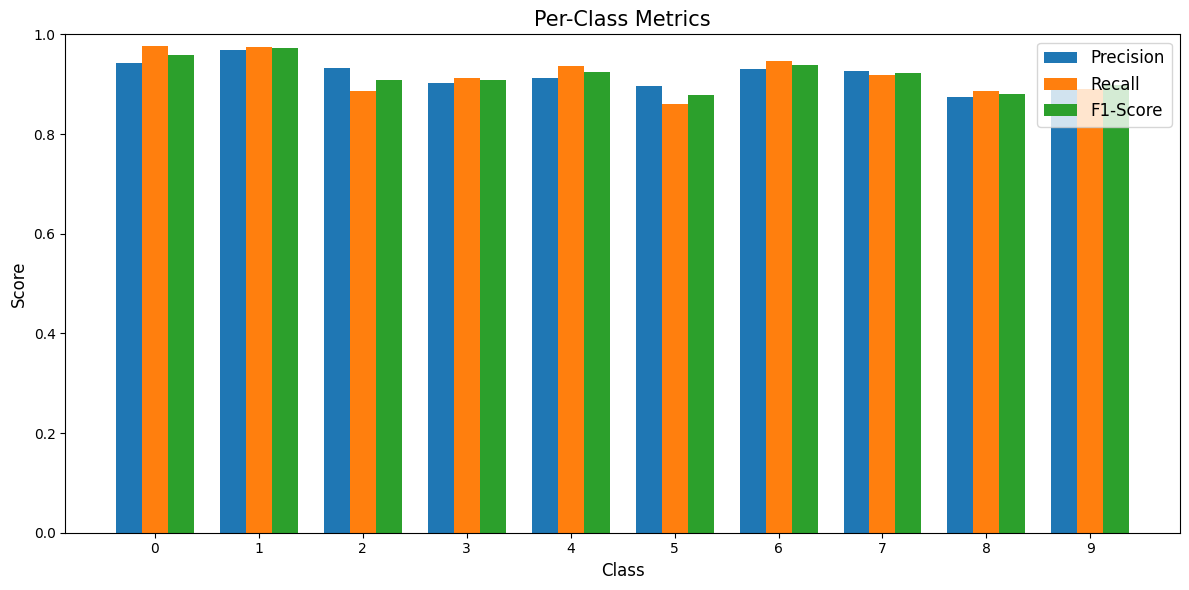

In [77]:
utils.plot_class_metrics(metrics)

## **5. Save Model**

In [78]:
np.savez(r'..\models\model_function1.npz', W=model1.W, b=model1.b)
np.savez(r'..\models\model_function2.npz', W=model2.W, b=model2.b)
np.savez(r'..\models\model_function3.npz', W=model3.W, b=model3.b)